In [22]:
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------------
def normalize_to_01(series, old_min, old_max):
    """
    Map a Pandas Series from [old_min..old_max] to [0..1].
    """
    return (series - old_min) / (old_max - old_min)


In [23]:
# ----------------------------------------------------------------------
# MODEL CLASSES
# ----------------------------------------------------------------------
class RewardLearner:
    """
    Simple Rescorla-Wagner:
      R_hat[t] = R_hat[t-1] + alpha_r * (R_t - R_hat[t-1])
    """
    def __init__(self, alpha_r=0.1, init_reward=3.5, sigma_r=0.7):
        self.alpha_r = alpha_r
        self.R_hat = init_reward
        self.sigma_r = sigma_r
    
    def update(self, received_reward):
        delta_r = received_reward - self.R_hat
        self.R_hat += self.alpha_r * delta_r
        return self.R_hat
    
    def belief_distribution(self):
        return norm(loc=self.R_hat, scale=self.sigma_r)


class EffortLearner:
    """
    Direct threshold feedback:
      E_hat[t+1] = E_hat[t] + alpha_e * (theta[t] - E_hat[t])
    """
    def __init__(self, alpha_e=0.1, init_effort=50.0):
        self.alpha_e = alpha_e
        self.E_hat = init_effort
    
    def update(self, true_threshold):
        delta_e = true_threshold - self.E_hat
        self.E_hat += self.alpha_e * delta_e
        # We can clip to [0..100] or [0..1] depending on the modeling choice outside.
        return self.E_hat


class EffortDiscounter:
    """
    We search over possible effort values (in either [0..100] or [0..1]),
    compute:
      p_success(e) = norm.cdf((e - E_hat)/sigma)
      SV(e)        = R_hat - kappa*e
      EU(e)        = SV(e)*p_success(e)
    Then either argmax or softmax.
    """
    def __init__(self,
                 kappa=0.05,
                 sigma=5.0,
                 beta=5.0,
                 policy='argmax',
                 use_fully_normalized=False):
        self.kappa = kappa
        self.sigma = sigma
        self.beta = beta
        self.policy = policy
        self.use_fully_normalized = use_fully_normalized

        if self.use_fully_normalized:
            # e-values in [0..1], in increments of 0.01
            self.e_values = np.linspace(0, 1, 101)
        else:
            # e-values in [0..100]
            self.e_values = np.arange(101)

    def choose_effort(self, R_hat, E_hat):
        EU_values = []

        for e in self.e_values:
            # p_success = norm.cdf((effort - E_hat)/sigma)
            p_success = norm.cdf((e - E_hat) / self.sigma)
            SV = R_hat - self.kappa * e
            EU = SV * p_success
            EU_values.append(EU)

        EU_values = np.array(EU_values)
        if self.policy == 'argmax':
            chosen_idx = np.argmax(EU_values)
            chosen_e = self.e_values[chosen_idx]
        else:
            # softmax
            max_eu = np.max(EU_values)
            exp_vals = np.exp(self.beta * (EU_values - max_eu))
            probs = exp_vals / np.sum(exp_vals)
            chosen_e = np.random.choice(self.e_values, p=probs)
        
        return chosen_e


In [24]:
# ----------------------------------------------------------------------
# SIMULATION
# ----------------------------------------------------------------------
def simulate_experiment(data,
                        num_trials=60,
                        use_fully_normalized=False,
                        ignore_zero_reward=True,
                        reward_learner_params=None,
                        effort_learner_params=None,
                        discounter_params=None):
    """
    If use_fully_normalized=True, then we convert:
      threshold in [20..90] -> [0..1],
      reward in [1..7] -> [0..1],
      and interpret efforts in [0..1].

    If use_fully_normalized=False, then we keep:
      threshold in [20..90] (raw),
      reward in [1..7] (raw),
      effort in [0..100].
    """

    # Default parameter dicts
    if reward_learner_params is None:
        reward_learner_params = {}
    if effort_learner_params is None:
        effort_learner_params = {}
    if discounter_params is None:
        discounter_params = {}
    
    # 1) Possibly normalize the data
    if use_fully_normalized:
        # Map threshold [20..90] => [0..1]
        data['threshold_norm'] = normalize_to_01(data['threshold'], 20, 90)
        # Map reward [1..7] => [0..1]
        data['reward_norm'] = normalize_to_01(data['reward'], 1, 7)

        # We'll also adapt initial guesses to be in [0..1].
        # For example, if the user gave init_effort=50.0, let's map it to 0.5 automatically:
        # Or you can do a direct override: effort_learner_params['init_effort'] = 0.5
        if 'init_effort' in effort_learner_params:
            # naive approach: new_init_effort = old_init_effort / 100
            effort_learner_params['init_effort'] = effort_learner_params['init_effort'] / 100.0

        # Similarly, if user sets an initial R_hat in [1..7], we can scale that, or just let them
        # pass in an appropriate "init_reward" from the start. Example:
        if 'init_reward' in reward_learner_params:
            # naive approach to scale from 1..7 => 0..1
            old_init_r = reward_learner_params['init_reward']
            new_init_r = (old_init_r - 1.0) / 6.0
            reward_learner_params['init_reward'] = new_init_r

        # Also let discounter know we're using normalized scale
        discounter_params['use_fully_normalized'] = True
    else:
        discounter_params['use_fully_normalized'] = False

    # 2) Create the learners and discounter
    RL = RewardLearner(**reward_learner_params)
    EL = EffortLearner(**effort_learner_params)
    discounter = EffortDiscounter(**discounter_params)

    # 3) Prepare for simulation
    results = {
        'trial': [],
        'threshold': [],
        'reward': [],
        'chosen_effort': [],
        'outcome': [],
        'R_hat': [],
        'E_hat': []
    }

    actual_num_trials = min(num_trials, len(data))

    # 4) Loop over trials
    for t in range(actual_num_trials):
        # Get threshold & reward for this trial
        if use_fully_normalized:
            threshold_t = data.iloc[t]['threshold_norm']
            reward_t = data.iloc[t]['reward_norm']
        else:
            threshold_t = data.iloc[t]['threshold']
            reward_t = data.iloc[t]['reward']

        if ignore_zero_reward and reward_t == 0:
            print(f"Trial {t+1}: Skipping zero-reward trial")
            continue

        # 4a) Choose effort
        chosen_e = discounter.choose_effort(RL.R_hat, EL.E_hat)

        # 4b) Probability of success
        p_success = norm.cdf((chosen_e - EL.E_hat) / discounter.sigma)
        outcome = np.random.binomial(1, p_success)

        # 4c) Received reward
        received_reward = reward_t if outcome == 1 else 0.0

        # 4d) Update the learners
        RL.update(received_reward)
        EL.update(threshold_t)

        # 4e) Store
        results['trial'].append(t+1)
        if use_fully_normalized:
            # Save the *normalized* threshold for clarity
            results['threshold'].append(threshold_t)
            results['reward'].append(reward_t)
        else:
            results['threshold'].append(threshold_t)
            results['reward'].append(reward_t)

        results['chosen_effort'].append(chosen_e)
        results['outcome'].append(outcome)
        results['R_hat'].append(RL.R_hat)
        results['E_hat'].append(EL.E_hat)

        # Debug print
        print(f"Trial {t+1}: threshold={threshold_t:.3f}, reward={reward_t:.3f}, "
              f"chosen_e={chosen_e:.3f}, outcome={outcome}, "
              f"R_hat={RL.R_hat:.3f}, E_hat={EL.E_hat:.3f}")

    return pd.DataFrame(results)


--- SIMULATING WITH RAW SCALE ---

Trial 1: threshold=48.000, reward=6.000, chosen_e=52.000, outcome=1, R_hat=4.500, E_hat=48.400
Trial 2: threshold=39.000, reward=7.000, chosen_e=56.000, outcome=1, R_hat=5.750, E_hat=40.880
Trial 3: threshold=58.000, reward=6.000, chosen_e=50.000, outcome=1, R_hat=5.875, E_hat=54.576
Trial 4: threshold=34.000, reward=7.000, chosen_e=63.000, outcome=1, R_hat=6.438, E_hat=38.115
Trial 5: threshold=48.000, reward=7.000, chosen_e=48.000, outcome=1, R_hat=6.719, E_hat=46.023
Trial 6: threshold=52.000, reward=7.000, chosen_e=56.000, outcome=1, R_hat=6.859, E_hat=50.805
Trial 7: threshold=52.000, reward=2.000, chosen_e=60.000, outcome=1, R_hat=4.430, E_hat=51.761
Trial 8: threshold=58.000, reward=7.000, chosen_e=59.000, outcome=1, R_hat=5.715, E_hat=56.752
Trial 9: threshold=57.000, reward=6.000, chosen_e=65.000, outcome=1, R_hat=5.857, E_hat=56.950
Trial 10: threshold=79.000, reward=5.000, chosen_e=66.000, outcome=1, R_hat=5.429, E_hat=74.590
Trial 11: thr

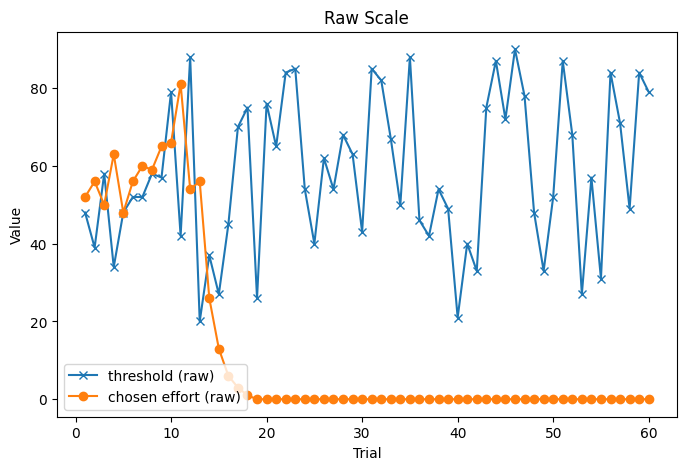


--- SIMULATING WITH FULLY NORMALIZED SCALE ---

Trial 1: threshold=0.400, reward=0.833, chosen_e=0.540, outcome=1, R_hat=0.583, E_hat=0.420
Trial 2: threshold=0.271, reward=1.000, chosen_e=0.460, outcome=1, R_hat=0.792, E_hat=0.301
Trial 3: threshold=0.543, reward=0.833, chosen_e=0.340, outcome=1, R_hat=0.812, E_hat=0.495
Trial 4: threshold=0.200, reward=1.000, chosen_e=0.530, outcome=1, R_hat=0.906, E_hat=0.259
Trial 5: threshold=0.400, reward=1.000, chosen_e=0.300, outcome=1, R_hat=0.953, E_hat=0.372
Trial 6: threshold=0.457, reward=1.000, chosen_e=0.410, outcome=1, R_hat=0.977, E_hat=0.440
Trial 7: threshold=0.457, reward=0.167, chosen_e=0.480, outcome=1, R_hat=0.572, E_hat=0.454
Trial 8: threshold=0.543, reward=1.000, chosen_e=0.490, outcome=1, R_hat=0.786, E_hat=0.525
Trial 9: threshold=0.529, reward=0.833, chosen_e=0.560, outcome=1, R_hat=0.810, E_hat=0.528
Trial 10: threshold=0.843, reward=0.667, chosen_e=0.570, outcome=1, R_hat=0.738, E_hat=0.780
Trial 11: threshold=0.314, rew

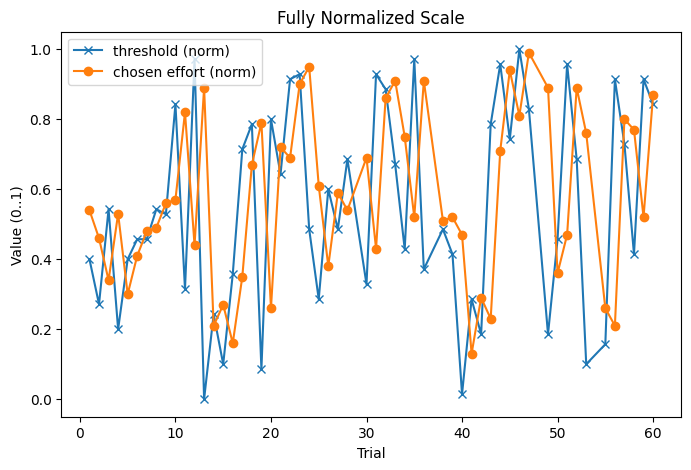

In [25]:
# ----------------------------------------------------------------------
# "MAIN" TO RUN BOTH OPTIONS
# ----------------------------------------------------------------------
def main():
    # Example synthetic data: threshold in [20..90], reward in [1..7].
    data = pd.DataFrame({
        'threshold': np.random.randint(20, 91, 60), # 60 trials
        'reward': np.random.randint(1, 8, 60)
    })

    # ----------------------------------
    # OPTION 1: RAW SCALE
    # ----------------------------------
    discounter_params_raw = {
        'kappa': 0.05,
        'sigma': 5.0,
        'beta': 0.0,  # argmax
        'policy': 'argmax',
        'use_fully_normalized': True # We'll set automatically in simulate_experiment
    }
    reward_learner_params_raw = {
        'alpha_r': 0.5,
        'init_reward': 3.0,   # in raw scale (roughly in the range of 1..7)
    }
    effort_learner_params_raw = {
        'alpha_e': 0.8,
        'init_effort': 50.0,  # in 0..100
    }

    print("\n--- SIMULATING WITH RAW SCALE ---\n")
    results_raw = simulate_experiment(
        data=data.copy(),
        num_trials=60,
        use_fully_normalized=False,
        reward_learner_params=reward_learner_params_raw,
        effort_learner_params=effort_learner_params_raw,
        discounter_params=discounter_params_raw
    )
    print("\nResults (head):\n", results_raw.head())

    # Plot example
    plt.figure(figsize=(8,5))
    plt.plot(results_raw['trial'], results_raw['threshold'], label="threshold (raw)", marker='x')
    plt.plot(results_raw['trial'], results_raw['chosen_effort'], label="chosen effort (raw)", marker='o')
    plt.title("Raw Scale")
    plt.xlabel("Trial")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # ----------------------------------
    # OPTION 2: FULLY NORMALIZED
    # ----------------------------------
    discounter_params_norm = {
        'kappa': 0.03,  # now cost for e=1 is 0.05
        'sigma': 0.01,  # you'd likely scale sigma down as well
        'beta': 0.0,
        'policy': 'argmax'
        # 'use_fully_normalized': True # We'll set automatically in simulate_experiment
    }
    reward_learner_params_norm = {
        'alpha_r': 0.5,
        'init_reward': 3.0,  # We'll scale it inside the function => ~ (3.0-1)/6=0.33
    }
    effort_learner_params_norm = {
        'alpha_e': 0.8,
        'init_effort': 50.0,  # We'll scale it => 0.5
    }

    print("\n--- SIMULATING WITH FULLY NORMALIZED SCALE ---\n")
    results_norm = simulate_experiment(
        data=data.copy(),
        num_trials=60,
        use_fully_normalized=True,
        reward_learner_params=reward_learner_params_norm,
        effort_learner_params=effort_learner_params_norm,
        discounter_params=discounter_params_norm
    )
    print("\nResults (head):\n", results_norm.head())

    # Plot example
    plt.figure(figsize=(8,5))
    plt.plot(results_norm['trial'], results_norm['threshold'], label="threshold (norm)", marker='x')
    plt.plot(results_norm['trial'], results_norm['chosen_effort'], label="chosen effort (norm)", marker='o')
    plt.title("Fully Normalized Scale")
    plt.xlabel("Trial")
    plt.ylabel("Value (0..1)")
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()
